# Model stats

In [1]:
import os
import time
import scipy
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# TODO SET ONCOLAB = TRUE IF WORKING ON COLAB
onColab = False
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE1/with_img_divided
  !ls

In [3]:
# TODO CHANGE DATASET_PATH AND PATH_TO_MODEL
path_to_model = './SubmissionModel'
dataset_path = './training'

batch_size = 128
validation_split = 0.3
def tl_preprocess(x):
  return tf.keras.applications.efficientnet.preprocess_input(x)

In [4]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
img_h, img_w = (256, 256)

def load_data(dontUseFun=True, fun=None, isTest = False):
  """
  load data (train, val, test)
  dontUseFun: if it's true then the data is not preprocessed. If it's false, the data is preprocessed with fun (which must not be none)
  """
  image_generator = ImageDataGenerator(preprocessing_function = fun, validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  
  if dontUseFun:
    image_generator = ImageDataGenerator(validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  


  # Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
  train_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='training',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)

  valid_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='validation',
                                                batch_size=batch_size,
                                                shuffle=False,
                                                seed=seed)
  test_gen = None
  if isTest:
    test_image_gen = ImageDataGenerator(preprocessing_function = fun)
    if dontUseFun:
      test_image_gen = ImageDataGenerator(rotation_range=30)
    
    test_gen = test_image_gen.flow_from_directory(directory=test_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=True, # sometimes, instead of train, we use the test for training
                                                seed=seed)
  return train_gen, valid_gen, test_gen

In [6]:
def preprocess(x):
  # x = clean_image(x)
  if tl_preprocess:
    return tl_preprocess(np.uint8(x))
  return x

In [7]:
train_gen, valid_gen, test_gen = load_data(False, preprocess)

Found 12270 images belonging to 14 classes.
Found 5248 images belonging to 14 classes.


In [8]:
model = tf.keras.models.load_model(path_to_model)

## Visualize performance

In [9]:
labels = list(train_gen.class_indices.keys())

In [10]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_gen.classes, y_pred)

Confusion Matrix


In [15]:
print(cm)

[[ 282    3    0    0    0    0    0    1    0    0    0    1    0    0
     0    0    0    2    0    0    0    2    0]
 [   0    0  135    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0  168    0    0    0    0    0    0    0    0    0    0
     0    0    0    2    0    0    0    0    0]
 [   0    0    0    0    0  342   14    0    0    0    1    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0  291  140    0    0    0    0    0
     0    1    0    0    0    0    0    0    0]
 [   0    0    1    0    0    0    0    0    0  518    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   3    0    0    0    0    0    0    0    0    0  232   52    0    1
     0    0    0    0    0    0    0    0    0]
 [   0    1    1    0    0    0    0    0    0    0    1    1  216    5
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    

In [11]:
# # Compute the classification metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
target = valid_gen.classes
predictions = Y_pred
accuracy = accuracy_score(target, np.argmax(predictions, axis=1))
precision = precision_score(target, np.argmax(predictions, axis=1), average='macro')
recall = recall_score(target, np.argmax(predictions, axis=1), average='macro')
f1 = f1_score(target, np.argmax(predictions, axis=1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

Accuracy: 0.0551
Precision: 0.066
Recall: 0.0423
F1: 0.0427


c:\Users\carpa\Desktop\Challenge\venv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!pip install seaborn

In [ ]:
# Let's replot the heatmap but this time we put vmax = 200, so that tomatoes don't cloud the colors of the heatmap and we can visualize the distribution a bit better
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels, vmax=200)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Visualize model

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 23)                29463 

You should consider upgrading via the 'c:\users\carpa\desktop\challenge\venv\scripts\python.exe -m pip install --upgrade pip' command.


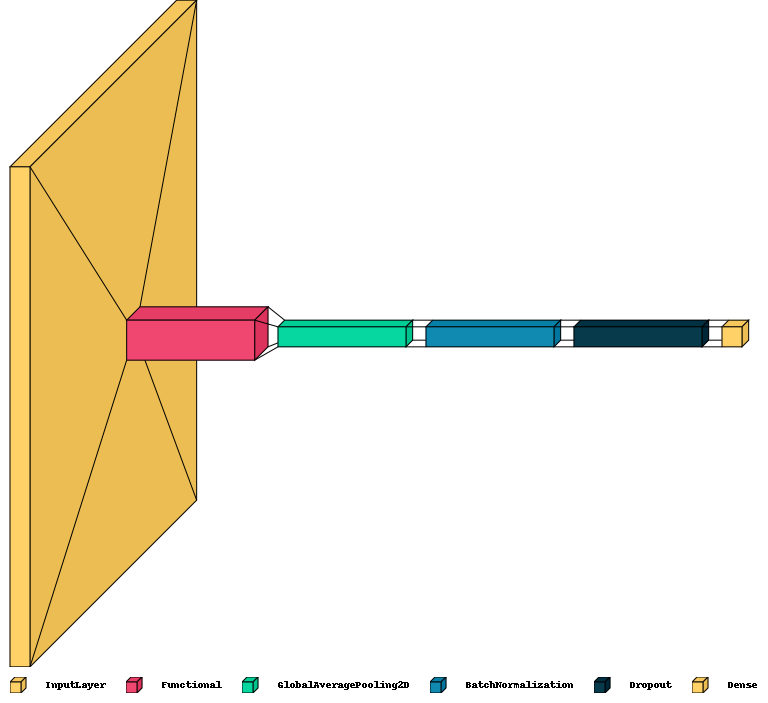

In [14]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=5, max_xy=500)